## 3.2 autograd
手动实现反向传播费时费力。autograd 能根据输入和前向过程自动构建计算图，并执行反向传播。  
关于计算图，详见 Christopher Olah 的[文章](http://colah.github.io/posts/2015-08-Backprop)

### 3.2.1 Variable
最新版 pytorch 文档显示，现在已不需要 `Variable(tensor)` 。用常规方法生成的 tensor 只要声明 `requires_grad = True` 就可以自动获得 variable 的身份，可以求导了。

In [2]:
from __future__ import print_function
import torch as t

In [3]:
a = t.ones((3,4), requires_grad = True)
a

tensor([[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]])

In [4]:
b = t.zeros((3,4), requires_grad=True)

In [5]:
c = a + b
c

tensor([[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]])

In [6]:
d = c.sum()
d.backward()
d

tensor(12.)

In [7]:
a.grad

tensor([[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]])

In [8]:
a.requires_grad, b.requires_grad, c.requires_grad

(True, True, True)

In [9]:
a.is_leaf, b.is_leaf, c.is_leaf

(True, True, False)

In [10]:
c.grad is None

True

In [11]:
def f(x):
    return x**2*t.exp(x)

def gradf(x):
    dx = 2*x*t.exp(x) + x**2*t.exp(x)
    return dx

In [12]:
x = t.randn((3,4), requires_grad = True)
y = f(x)
y

tensor([[ 0.5167,  0.0792,  1.7355,  0.3216],
        [ 0.4098,  0.6665,  0.9990,  0.2035],
        [ 2.8812,  0.5357,  0.0344,  0.5248]])

In [13]:
y.backward(t.ones(y.shape))
x.grad

tensor([[-0.1298,  0.7164,  5.7815, -0.4085],
        [-0.3209,  2.8746,  3.8402, -0.4606],
        [ 8.5332,  0.0513,  0.4383, -0.1044]])

In [14]:
gradf(x)

tensor([[-0.1298,  0.7164,  5.7815, -0.4085],
        [-0.3209,  2.8746,  3.8402, -0.4606],
        [ 8.5332,  0.0513,  0.4383, -0.1044]])

### 3.2.2 计算图
autograd 底层采用了计算图，是一种有向无环图，用于记录算子和变量之间的关系。  
autograd 会随着用户的操作，记录对当前 tensor 的所有操作，由此建立一个有向无环图。

#### 下面我们推理反向传播计算图

<img src = 'imgs/com_graph_backward.png' style = 'width:200px;height:300px;float:left'>  

In [15]:
x = t.ones(1)
b = t.rand((1),requires_grad = True)
w = t.rand((1),requires_grad = True)
y = w * x
z = y + b

In [16]:
x.requires_grad, b.requires_grad, w.requires_grad

(False, True, True)

In [17]:
# 查看该 tensor 的反向传播函数
z.grad_fn

In [18]:
z.grad_fn.next_functions

((<MulBackward1 at 0x7ff91efcf978>, 0),
 (<AccumulateGrad at 0x7ff91efcf438>, 0))

In [19]:
z.grad_fn.next_functions[0][0] == y.grad_fn

True

In [20]:
y.grad_fn.next_functions

((<AccumulateGrad at 0x7ff91efcfa90>, 0), (None, 0))

In [21]:
w.grad_fn, x.grad_fn

(None, None)

In [22]:
z.backward(retain_graph = True)
w.grad

tensor([ 1.])

pytorch 使用的是**动态图**，它的计算图在每次前向传播时都是从头开始构建，所以能够使用 for，if 等语句根据需求创建计算图。这意味着你不需要事先构建所有可能用到的途径，因为图在运行时才构建。

In [23]:
def abs(x):
    if x.data[0] > 0: return x
    else: return -x
x = t.ones((1), requires_grad = True)
y = abs(x)
y.backward()
print(x.grad)

tensor([ 1.])


In [25]:
x = -1*t.ones((1), requires_grad = True)
y = abs(x)
y.backward()
print(x.grad)

None


#### 注意
pytorch 文档已经把 Variable 列为“过时”，以后不需要用 `Variable(tensor)` 来对 tensor 使用 autograd，因为这样得到的结果是个 tensor。直接创建 tensor，即可 autograd。  
我已在教程页面提交 issue。  
作者已回复，表示下一版会修改。

In [26]:
x = t.ones(1, requires_grad = True)
w = t.rand(1, requires_grad = True)
y = x * w
y.backward()
x.data


tensor([ 1.])

#### 计算图特点总结


* 由用户创建的节点成为叶子节点 `is_leaf` ，其梯度是累加的。
* tensor 默认不需要求导。手动设置 `requires_grad = True` 或者用 `x.requires_grad_()` 之后，所有依赖于这个 tensor 的节点都可以求导。
* 非叶子节点的梯度计算完后即被清空，如需获取值可以使用 autograd.grad 或 hook 技术。
* 对 tensor 的修改才能被记录，避免直接修改 tensor.data，因为这样修改无法被计算图记录。

#### 扩展 autograd 
略。

### 3.2.4 再试牛刀——用 autograd backward 实现线性回归（弃用教程里的 Variable 方法）

#### 准备数据

In [28]:
import torch as t
import matplotlib.pyplot as plt
from IPython import display

In [29]:
t.manual_seed(1000)

def get_fake_data(batch_size = 20):
    x = t.randn((batch_size,1), requires_grad = True) * 10
    y = 2 * x + 3 + t.randn(batch_size,1) * 4 # true w = 2, b = 3
    return x,y

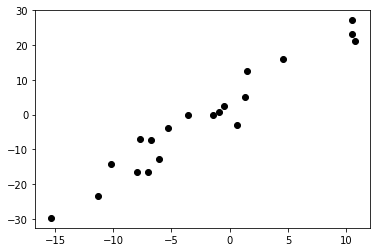

In [30]:
x,y = get_fake_data() # x,y are tensors that can be taken grad
plt.scatter(x.squeeze().data,y.squeeze().data, color = 'k')

#### 计算损失，自动求导，更新参数

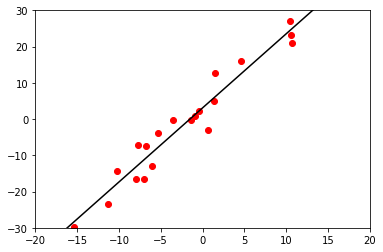

training is completed.
predicted: w = 2.049903, b = 3.177377
true:      w = 2.000000, b = 3.000000


In [31]:
# 初始化参数 w 和 b
w = t.rand((1,1), requires_grad = True)
b = t.zeros((1,1), requires_grad = True)

# 学习率，轮数
lr = 0.001     # lr>特定值则出现梯度爆炸，loss 趋于无穷大。为什么？
epochs = 20000

# 开始训练
for epoch in range(epochs):

    # 前向
    y_predicted = x.mm(w) + b.expand_as(y)
    
    # 计算损失
    loss = 0.5 * (y - y_predicted) ** 2
    loss = loss.sum()
    
    # 用 autograd 自动求梯度
    loss.backward()
    
    # 更新参数
    w.data.sub_(lr * w.grad.data)
    b.data.sub_(lr * b.grad.data)
    
    # 注意每次反向传播前，要将梯度归零
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    # 画图
    if epoch % 2 == 1 and epoch <= 200:
        
        print('epoch: {}, loss: {}'.format(epoch,loss))
        
        # 抹去前一步输出，重新画图
        display.clear_output(wait = True)
        
        # 生成用于画图的数据
        xd = t.arange(-20,20).view(-1,1)
        yd = xd.mm(w) + b.expand_as(xd)
        
        # 画出回归线
        plt.plot(xd.data.numpy(),yd.data.numpy(),color = 'k')
        
        # 画出原始数据
        plt.scatter(x.squeeze().data, y.squeeze().data, color = 'r')
        
        plt.xlim(-20,20)
        plt.ylim(-30,30)
        plt.show()
        plt.pause(0.05)
        
print('training is completed.')

print('predicted: w = {:03f}, b = {:03f}'.format(w.squeeze(), b.squeeze()))
print('true:      w = {:03f}, b = {:03f}'.format(2,3))